In [1]:
from pipeline.feature_engineering.dao.sussex_huawei_dao import SussexHuaweiDAO
from pipeline.feature_engineering.preprocessing.sussex_huawei_preprocessor import SussexHuaweiPreprocessor
from pipeline.feature_engineering.feature_extraction.baseline_extractor import BaselineExtractor
import matplotlib as plt
import seaborn as sns

In [2]:
dao = SussexHuaweiDAO()
preprocessor = SussexHuaweiPreprocessor()
extractor = BaselineExtractor()

In [3]:
# 1. Load Data
label_column_names = ['coarse_label', 'fine_label', 'road_label']
labels = dao.read_data(
            './data_sets/sussex_huawei/User1/220617/Label.txt', #TODO: Pack in config/.env
            column_names=label_column_names, use_columns=[1, 2, 3])
data_column_names = ['time', 'acceleration_x', 'acceleration_y', 'acceleration_z', #TODO: Pack in config/.env
                             #'gyroscope_x', 'gyroscope_y', 'gyroscope_z',
                             #'magnetometer_x', 'magnetometer_y', 'magnetometer_z',
                             'orientation_w', 'orientation_x', 'orientation_y', 'orientation_z',
                             'gravity_x', 'gravity_y', 'gravity_z',
                             #'linear_acceleration_x', 'linear_acceleration_y', 'linear_acceleration_z',
                             ]
data = dao.read_data(
        './data_sets/sussex_huawei/User1/220617/Bag_Motion.txt', #TODO: Pack in config/.env
        column_names=data_column_names, use_columns=[0,1,2,3,10,11,12,13,14,15,16]) #4,5,6,7,8,9,17,18,19


In [4]:
# 2. Preprocessing

# 2.1 Convert unix time (ms) to date time
data = preprocessor.convert_unix_to_datetime(data, column = 'time', unit = 'ms')

# 2.2 Label data and remove NaNs
data = preprocessor.label_data(data, labels)
data = preprocessor.remove_nans(data, replacement_mode='del_row')

# 2.3 Normalization
acelerometer_columns = ['acceleration_x', 'acceleration_y', 'acceleration_z']
gravity_columns = ['gravity_x', 'gravity_y', 'gravity_z']
orientation_columns = ['orientation_x', 'orientation_y', 'orientation_z', 'orientation_w']

data = preprocessor.project_accelerometer_to_global_coordinates(
            data, 
            mode ='gravity', 
            target_columns = acelerometer_columns,
            args = gravity_columns)

data = preprocessor.project_accelerometer_to_global_coordinates(
            data, 
            mode ='orientation', 
            target_columns = acelerometer_columns,
            args = orientation_columns)


#data = preprocessor.znormalize_quantitative_data(data, data_column_names[1:])
#data = preprocessor.min_max_normalize_quantitative_data(data, data_column_names[1:])

# 2.4 Segment data
# Coarse Label: Null=0, Still=1, Walking=2, Run=3, Bike=4, Car=5, Bus=6, Train=7, Subway=8
# Road Label: City=1, Motorway=2, Countryside=3, Dirt road=4, Null=0
selected_coarse_labels = [5]
selected_road_labels = [1, 3]
car_segments = preprocessor.segment_data(data, mode='labels', 
                                 label_column='coarse_label', 
                                 args=selected_coarse_labels)

data_segments = []
for car_segment in car_segments:
        road_segments = preprocessor.segment_data(car_segment, mode='labels', 
                                  label_column='road_label',
                                  args=selected_road_labels
                                )
        for road_segment in road_segments:
            data_segments.append(road_segment)
            
# 2.5 Low Pass filtering -> #100 Hz to 10 Hz
for ind in range(len(data_segments)):
    data_segments[ind] = data_segments[ind].set_index('time')
    data_segments[ind] = preprocessor.resample_quantitative_data(data_segments[ind], freq='1000ms')
    
# 2.6 Outlier removal:
for ind in range(len(data_segments)):
    data_segments[ind] = preprocessor.remove_outliers_from_quantitative_data(
        data_segments[ind],
        replacement_mode = 'quantile',
        columns = acelerometer_columns,
        quantile = 0.99
    )
    
# 2.7 Dimensionality reduction:
for ind in range(len(data_segments)):
    data_segments[ind] = preprocessor.reduce_quantitativ_data_dimensionality(
        data = data_segments[ind],
        mode ='euclidean',
        columns = acelerometer_columns,
        reduced_column_name = 'acceleration_abs'
    )

1


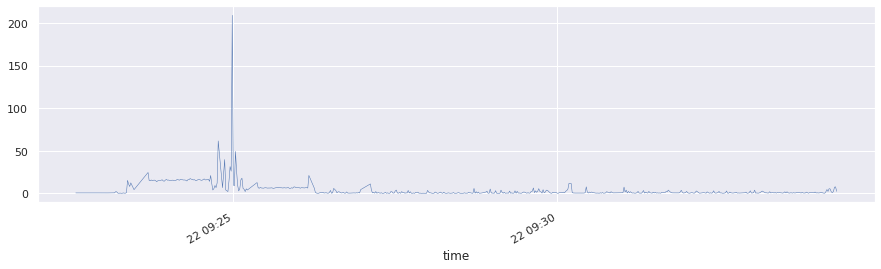

In [5]:
# Visual anlaysis:
sns.set(rc={'figure.figsize':(15, 4)})
data_segments[0]['acceleration_abs'].plot(linewidth=0.5);
print(data_segments[0]['road_label'].iloc[0]); # 1 = City



1


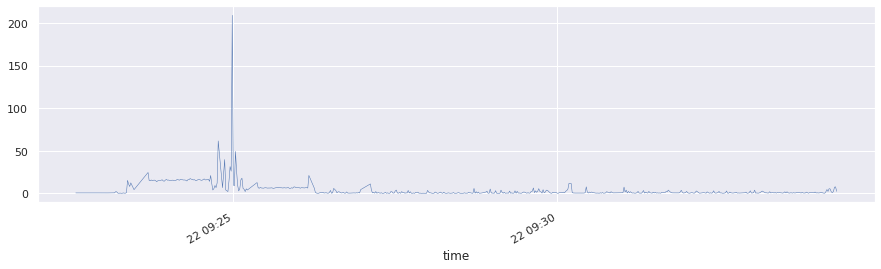

In [6]:
sns.set(rc={'figure.figsize':(15, 4)})
data_segments[0]['acceleration_abs'].plot(linewidth=0.5);
print(data_segments[0]['road_label'].iloc[0]); # 3 = Country

In [7]:
#y is target vecote, we need at least 2 classes to learn features for tsfresh
import pandas
import warnings
warnings.simplefilter("ignore")

seg1 = data_segments[0][['acceleration_x', 'road_label']].reset_index(drop=True)
seg2 = data_segments[5][['acceleration_x', 'road_label']].reset_index(drop=True)
seg = pandas.concat([seg1, seg2])
seg['road_label']= (seg['road_label'] > 2.0).astype(int)
seg.reset_index()
y = seg[['road_label']].reset_index(drop=True)
seg['id'] = range(1, len(seg) + 1)
y['id'] = range(1, len(seg) + 1)
y.reset_index()
y['road_label'].index=list(y['id'])
#print(y['road_label'])
#print(seg)


feature_maxtrix = extractor.extract_features(data = seg, args = ['id', y['road_label'], 16])

Feature Extraction: 100%|██████████| 79/79 [00:10<00:00,  7.73it/s]
 'acceleration_x__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"rvalue"'
 'acceleration_x__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"slope"'
 ... 'road_label__spkt_welch_density__coeff_2'
 'road_label__spkt_welch_density__coeff_5'
 'road_label__spkt_welch_density__coeff_8'] did not have any finite values. Filling with zeros.


Int64Index([   1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
            ...
            1836, 1837, 1838, 1839, 1840, 1841, 1842, 1843, 1844, 1845],
           dtype='int64', name='id', length=1845)
Int64Index([   1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
            ...
            1836, 1837, 1838, 1839, 1840, 1841, 1842, 1843, 1844, 1845],
           dtype='int64', length=1845)


In [8]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [9]:
import pandas
#y.index=list(y.index)
#print(y['road_label'].index)
#print(seg.index)

In [10]:
#print(features.keys())

In [11]:
#print(features['acceleration_x__fft_coefficient__coeff_0__attr_"abs"'])

In [13]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
clf.fit(feature_maxtrix, y)  

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=2, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [17]:
y2 = clf.predict(feature_maxtrix)

In [22]:
print(y['road_label'], y2)

1       0
2       0
3       0
4       0
5       0
6       0
7       0
8       0
9       0
10      0
11      0
12      0
13      0
14      0
15      0
16      0
17      0
18      0
19      0
20      0
21      0
22      0
23      0
24      0
25      0
26      0
27      0
28      0
29      0
30      0
       ..
1816    1
1817    1
1818    1
1819    1
1820    1
1821    1
1822    1
1823    1
1824    1
1825    1
1826    1
1827    1
1828    1
1829    1
1830    1
1831    1
1832    1
1833    1
1834    1
1835    1
1836    1
1837    1
1838    1
1839    1
1840    1
1841    1
1842    1
1843    1
1844    1
1845    1
Name: road_label, Length: 1845, dtype: int64 [[  0 509]
 [  0 509]
 [  0 509]
 ...
 [  1 935]
 [  1 935]
 [  1 935]]
